In [1]:
import cv2
import os
import numpy as np

In [2]:
def extract_frames_from_videos(video_dir, output_dir, frame_rate=5):
    """Extract frames from videos and save them into subdirectories based on the video category."""
    class_names = ['LegalBall','Wide']  # Define class labels

    for class_name in class_names:
        class_folder = os.path.join(video_dir, class_name)
        output_class_dir = os.path.join(output_dir, 'extracted_frames', class_name)
        os.makedirs(output_class_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        for video_file in os.listdir(class_folder):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_folder, video_file)
                video = cv2.VideoCapture(video_path)
                success, image = video.read()
                frame_count = 0
                while success:
                    if frame_count % frame_rate == 0:  # Capture frame at specific intervals
                        frame_filename = f"{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg"
                        frame_output_path = os.path.join(output_class_dir, frame_filename)
                        image_resized = cv2.resize(image, (224, 224))  # Resize for CNN
                        cv2.imwrite(frame_output_path, image_resized)  # Save frame
                    success, image = video.read()
                    frame_count += 1

In [3]:
video_dir = 'Wide/'  # Path to your dataset directory 
output_dir = 'Wide/data/'  # Root directory where all data will be saved

In [4]:
extract_frames_from_videos(video_dir, output_dir)

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2

In [6]:
def load_data_from_frames(output_dir):
    """Load frames from directories and prepare the data for training."""
    class_names = ['LegalBall','Wide']
    data = []
    labels = []

    for class_id, class_name in enumerate(class_names):
        class_folder = os.path.join(output_dir, 'extracted_frames', class_name)
        for frame_file in os.listdir(class_folder):
            if frame_file.endswith('.jpg'):
                frame_path = os.path.join(class_folder, frame_file)
                image = cv2.imread(frame_path)
                data.append(image)
                labels.append(class_id)  # Assign class label

    data = np.array(data)
    labels = np.array(labels)
    
    # Normalize the frames
    data = data.astype('float32') / 255.0
    
    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=4)

    return data, labels


In [7]:
# Load frames and labels
frames_data, labels_data = load_data_from_frames(output_dir)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(frames_data, labels_data, test_size=0.2, random_state=42)

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Define the model
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # CNN part wrapped in TimeDistributed (to apply the CNN to each frame)
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    # LSTM part
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer (4 classes: No Ball, Legal Ball, Wide, LBW)
    model.add(Dense(4, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# Define the input shape: (10 frames, 224x224 pixels, 3 color channels)
input_shape = (10, 224, 224, 3)
model = create_cnn_lstm_model(input_shape)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 222, 222, 32)    │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 222, 222, 32)    │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 111, 111, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 109, 109, 64)    │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 109, 109, 64)    │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 54, 54, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 52, 52, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 52, 52, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 26, 26, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 86528)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │      22,167,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,270,788 (84.96 MB)

 Trainable params: 22,270,340 (84.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Data augmentation (to reduce overfitting and introduce more data variety)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [14]:
# Apply augmentation frame by frame before creating sequences
def augment_frames(X_train):
    augmented_frames = []
    for frame in X_train:
        augmented_frame = datagen.random_transform(frame)
        augmented_frames.append(augmented_frame)
    return np.array(augmented_frames)


In [15]:
# Function to create frame sequences for the model
def create_frame_sequences(data, labels, sequence_length=10):
    sequences = []
    sequence_labels = []
    
    for i in range(0, len(data) - sequence_length, sequence_length):
        sequences.append(data[i:i + sequence_length])
        sequence_labels.append(labels[i + sequence_length - 1])  # Use the label of the last frame in the sequence
    
    return np.array(sequences), np.array(sequence_labels)

In [16]:
# Example data (X_train, y_train) should be processed with your dataset
# Assuming X_train and y_train are preprocessed
# Manually augment data frame by frame
X_train_augmented = augment_frames(X_train)

In [17]:
# Group the frames into sequences of 10 frames each
X_train_seq, y_train_seq = create_frame_sequences(X_train_augmented, y_train, sequence_length=10)
X_test_seq, y_test_seq = create_frame_sequences(X_test, y_test, sequence_length=10)

In [18]:
# Define learning rate scheduler and checkpoint
checkpoint = ModelCheckpoint('wide_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [19]:
# Train the model using the sequences of frames
history = model.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=4,
                    validation_data=(X_test_seq, y_test_seq),
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4123 - loss: 1.2972
Epoch 1: val_loss improved from inf to 0.76340, saving model to wide_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - accuracy: 0.4137 - loss: 1.2944 - val_accuracy: 0.8049 - val_loss: 0.7634 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5744 - loss: 0.9660
Epoch 2: val_loss improved from 0.76340 to 0.49611, saving model to wide_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - accuracy: 0.5755 - loss: 0.9643 - val_accuracy: 0.9024 - val_loss: 0.4961 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8004 - loss: 0.6631
Epoch 3: val_loss improved from 0.49611 to 0.42773, saving model to wide_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.7994 - loss: 0.6635 - val_accuracy: 0.9024 - val_loss: 0.4277 - learning_rate: 1.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8563 

In [20]:
import pandas as pd

In [21]:
# Create the logs directory
logs_dir = os.path.join(output_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [22]:
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

In [23]:
# Save the training history to CSV
log_file_path = os.path.join(logs_dir, 'training_log.csv')
history_df.to_csv(log_file_path, index=False)

In [24]:
import matplotlib.pyplot as plt

In [25]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

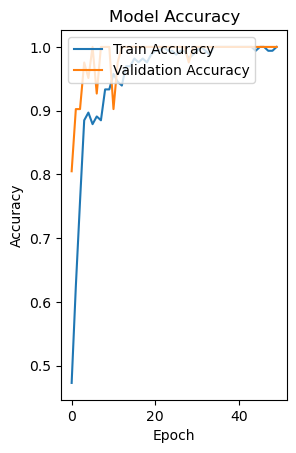

In [26]:
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

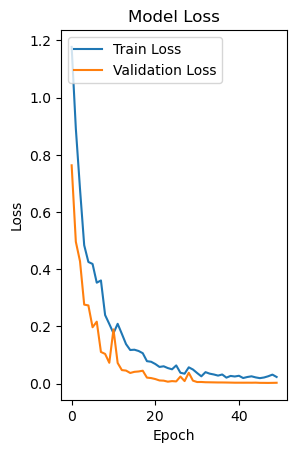

In [27]:
# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

In [28]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>